# Forberedelsen af data

In [1]:
# RBF with time series
#Libriaries & Models
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

import torch
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

import importlib
import src # Random seed set here
importlib.reload(src)

No GPU available.
Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Python random seed set.
NumPy random seed set.
PyTorch random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Set path for our project

In [2]:
# drive_path = '/content/drive/MyDrive/00_DTU/5. Semester/Deep Learning/02456-deep-learning-project-main/data/raw'
#drive_path = '/content/drive/MyDrive/02456-deep-learning-project-main/data/raw'

# local_path = r'C:\Users\lucia\OneDrive\Dokumente\GitHub\02456-deep-learning-project\data\raw'  # if you're folder structure is as defined above and you want to run locally
current_path = os.getcwd()
local_path = os.path.join(current_path, 'data', 'raw')


<!-- Access the datasets -->

In [3]:
# Find all CSV files in the specified path
csv_files = glob.glob(os.path.join('data', 'raw', 'wind_speed_*.csv'))
# Read each CSV file into a DataFrame and store in a dictionary
dataframes = {}
for file in csv_files:
    df_name = os.path.basename(file).replace(".csv", "")  # Extract file name without extension
    dataframes[df_name] = pd.read_csv(file)

# Display keys (file names) to ensure everything loaded correctly
print("Loaded datasets:", list(dataframes.keys()))


Loaded datasets: ['wind_speed_19_n', 'wind_speed_13_n', 'wind_speed_11_n', 'wind_speed_15_n', 'wind_speed_17_n']


In [4]:
# For eksempel for at få adgang til 'wind_speed_11_n' data
wind_speed_11_df = dataframes['wind_speed_15_n']
print(wind_speed_11_df.head())  # Se de første par rækker af dataene


           Mx1          Mx2         Mx3          My1          My2  \
0  5135.514141  -632.018403 -502.290212  8804.933549  3930.929887   
1  5446.065240 -1112.603015 -286.715582  8293.780681  4337.857944   
2  5001.160903  -547.519926 -504.268986  8655.390593  3854.436694   
3  4875.234131  -642.151129 -386.656840  8302.786656  4538.536744   
4  4872.189068  -643.406021 -126.689990  8230.635251  4012.179658   

           My3        Mz1        Mz2        Mz3     Theta  ...       Vwy  \
0  7271.332052 -46.785316 -26.395576  24.996557  1.490672  ...  2.755655   
1  6767.032199 -45.441826 -25.880159  24.945032  1.526129  ...  2.658961   
2  6922.958281 -44.297226 -25.170956  24.973219  1.515226  ...  2.938581   
3  6603.542162 -42.947720 -24.713062  25.132181  1.541227  ...  3.106474   
4  6329.915987 -41.734791 -24.310396  25.351448  1.557755  ...  3.088724   

        Vwz     beta1     beta2     beta3    dbeta1    dbeta2    dbeta3  \
0 -0.005151  0.145057  0.144386  0.144536 -0.005971  

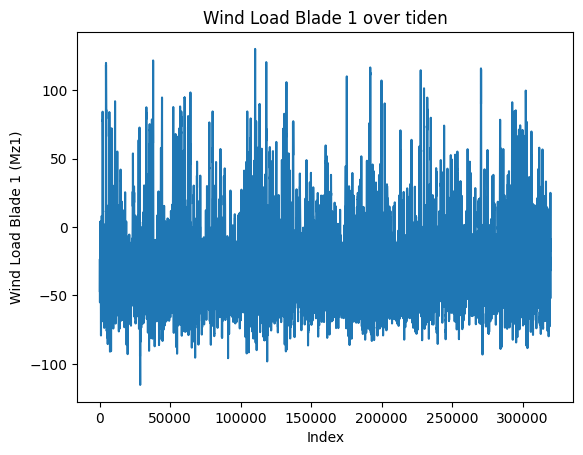

In [5]:
# Plotting et eksempel på Wind Load Blade 1 fra wind_speed_11_n
plt.plot(wind_speed_11_df['Mz1'])
plt.xlabel('Index')
plt.ylabel('Wind Load Blade 1 (Mz1)')
plt.title('Wind Load Blade 1 over tiden')
plt.show()


Samle alle datasets, så alt data bliver anvendt for modellen

In [6]:
# Læs og kombiner alle datasæt i én DataFrame
dataframes = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

print("Kombineret datasæts form:", combined_df.shape)

Kombineret datasæts form: (1600005, 21)


In [7]:
def create_time_delayed_features_optimized(df, input_features, time_steps=3):
    """
    Create time-delayed features for a given DataFrame using vectorized operations.

    Args:
    - df: The DataFrame containing the scaled data.
    - input_features: The list of input feature names.
    - time_steps: The number of previous time steps to include (default is 3).

    Returns:
    - A DataFrame with time-delayed features.
    """
    delayed_df = pd.DataFrame(index=df.index)
    new_input_features = []
    # For each feature, create shifted columns for each time delay and add to the DataFrame
    for feature in input_features:
        for t in range(time_steps + 1):
            delayed_df[f"{feature}_t-{t}"] = df[feature].shift(t)
            new_input_features.append(f"{feature}_t-{t}")

    # Drop rows with NaN values (from initial time steps with no delay data)
    delayed_df.dropna(inplace=True)
    return delayed_df, new_input_features


# RBF - Implementation

In [8]:
class RBFNetwork:
    def __init__(self, centers, sigma=1.0):
        self.centers = centers  # Centrene for RBF-enhederne (det skjulte lag)
        self.sigma = sigma      # Spredningsparameter for Gaussian-funktionen
        self.weights = None     # Vægte til outputlaget

    def _rbf(self, X):
        # Calculates radial basis functions (Gaussian) for input X
        distances = cdist(X, self.centers, 'euclidean')  # Distance from input to each center
        G = np.exp(-distances ** 2 / (2 * self.sigma ** 2))
        assert not np.isnan(G).any(), "NaN in RBF activations"
        return np.exp(-distances ** 2 / (2 * self.sigma ** 2))  # Gaussian RBF

    def fit(self, X, y):
    # Train the model (calculate weights based on target variable y)
        G = self._rbf(X)  # Calculate activations in the hidden layer
        self.weights = pinv(G).dot(y)  # Calculate weights for the output layer (using pseudo-inverse)
        #self.weights = np.linalg.lstsq(G, y, rcond=None)[0]
        assert not np.isnan(self.weights).any(), "NaN in weights"

    def predict(self, X):
        # Forudsig output for nye data
        G = self._rbf(X)
        predictions = G.dot(self.weights)
        assert not np.isnan(predictions).any(), "NaN in predictions"
        return G.dot(self.weights)


In [9]:
# Learn function
def learn(input_features, num_center, sigma, time_steps):

  # Select the output features we want to predict
  output_features = ['Mz1', 'Mz2', 'Mz3']

  # Filter data to only include the desired columns
  filtered_df = combined_df[input_features + output_features]

  # Normalize all features in the combined dataset
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(filtered_df)

  # Convert back to a DataFrame to be able to access columns by name
  combined_df_scaled = pd.DataFrame(scaled_data, columns=filtered_df.columns)

  # Create time-delayed features for the input features
  delayed_input_df, input_features = create_time_delayed_features_optimized(combined_df_scaled, input_features, time_steps)

  # Merge the time-delayed input features with the original output features (Mz1, Mz2, Mz3)
  final_df = pd.concat([delayed_input_df.reset_index(drop=True), combined_df_scaled[output_features].iloc[3:].reset_index(drop=True)], axis=1)
  final_df = final_df.dropna(subset=output_features)

  #rename the keys for input and output
  all_features = final_df.columns

  # CHECK WHY THE LAST VALUES ARE NAN AND SOFTCODE!!!
  # set test and train and centers for the model
  X = final_df[input_features]   # Input variables
  y = final_df[output_features]  # Output variables

  # Split dataene i træning og test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Antag at X_train er en NumPy-array (hvis det er en DataFrame, konverter den med .values)
  X_train = X_train.values if hasattr(X_train, 'values') else X_train
  y_train = y_train.values if hasattr(y_train, 'values') else y_train

  # Apply K-Means to X_train to find cluster centers
  kmeans = KMeans(n_clusters=num_center, n_init=10, random_state=0)
  kmeans.fit(X_train)

  # The cluster centers will serve as the RBF centers
  centers = kmeans.cluster_centers_


  rbf_net = RBFNetwork(centers, sigma)
  rbf_net.fit(X_train, y_train)

  y_train_pred = rbf_net.predict(X_train)
  y_pred = rbf_net.predict(X_test)

  # calculate MSE
  mse_train = mean_squared_error(y_train,y_train_pred)
  mse_test = mean_squared_error(y_test, y_pred)

  return mse_train, mse_test, y_pred, y_test


In [10]:
def variable_timestep(input_features, num_center, sigma, time_step_list):

  # Select the output features we want to predict
  output_features = ['Mz1', 'Mz2', 'Mz3']

  # Filter data to only include the desired columns
  filtered_df = combined_df[input_features + output_features]

  # Normalize all features in the combined dataset
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(filtered_df)

  # Convert back to a DataFrame to be able to access columns by name
  combined_df_scaled = pd.DataFrame(scaled_data, columns=filtered_df.columns)

  mse_train_list = []
  mse_test_list = []

  for time_step in time_step_list:
    # Create time-delayed features for the input features (using 3 previous time steps)
    delayed_input_df, time_input_features = create_time_delayed_features_optimized(combined_df_scaled, input_features, time_step)

    # Merge the time-delayed input features with the original output features (Mz1, Mz2, Mz3)
    final_df = pd.concat([delayed_input_df.reset_index(drop=True), combined_df_scaled[output_features].iloc[3:].reset_index(drop=True)], axis=1)
    final_df = final_df.dropna(subset=output_features)

    #rename the keys for input and output
    all_features = final_df.columns

    # set test and train and centers for the model
    X = final_df[time_input_features]   # Input variables
    y = final_df[output_features]  # Output variables

    # Split dataene i træning og test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Antag at X_train er en NumPy-array (hvis det er en DataFrame, konverter den med .values)
    X_train = X_train.values if hasattr(X_train, 'values') else X_train
    y_train = y_train.values if hasattr(y_train, 'values') else y_train


    # Apply K-Means to X_train to find cluster centers
    kmeans = KMeans(n_clusters=num_center, n_init=10, random_state=0)
    kmeans.fit(X_train)

    # The cluster centers will serve as the RBF centers
    centers = kmeans.cluster_centers_

    rbf_net = RBFNetwork(centers, sigma)
    rbf_net.fit(X_train, y_train)

    y_train_pred = rbf_net.predict(X_train)
    y_pred = rbf_net.predict(X_test)

    # calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


  #plotting the error
  plt.plot(time_step_list, mse_train_list, label='Train error', color = 'orange')
  plt.plot(time_step_list,mse_test_list, label='Validation error', color='green')
  plt.xlabel('Number of previous time steps included')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

  print(mse_train_list, mse_test_list)
  return mse_train_list, mse_test_list


In [11]:
# Learn function
def variable_sigma(input_features, num_center, sigma_list, time_steps):

  # Select the output features we want to predict
  output_features = ['Mz1', 'Mz2', 'Mz3']

  # Filter data to only include the desired columns
  filtered_df = combined_df[input_features + output_features]

  # Normalize all features in the combined dataset
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(filtered_df)

  # Convert back to a DataFrame to be able to access columns by name
  combined_df_scaled = pd.DataFrame(scaled_data, columns=filtered_df.columns)

  # Create time-delayed features for the input features (using 3 previous time steps)
  delayed_input_df, input_features = create_time_delayed_features_optimized(combined_df_scaled, input_features, time_steps)

  # Merge the time-delayed input features with the original output features (Mz1, Mz2, Mz3)
  final_df = pd.concat([delayed_input_df.reset_index(drop=True), combined_df_scaled[output_features].iloc[3:].reset_index(drop=True)], axis=1)
  final_df = final_df.dropna(subset=output_features)
  #rename the keys for input and output
  all_features = final_df.columns

  # set test and train and centers for the model
  X = final_df[input_features]   # Input variables
  y = final_df[output_features]  # Output variables

  # Split dataene i træning og test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Antag at X_train er en NumPy-array (hvis det er en DataFrame, konverter den med .values)
  X_train = X_train.values if hasattr(X_train, 'values') else X_train
  y_train = y_train.values if hasattr(y_train, 'values') else y_train

  # Apply K-Means to X_train to find cluster centers
  kmeans = KMeans(n_clusters=num_center, n_init=10, random_state=0)
  kmeans.fit(X_train)

  # The cluster centers will serve as the RBF centers
  centers = kmeans.cluster_centers_

  # Train the model with different sigmas
  mse_train_list = []
  mse_test_list = []

  for sigma in sigma_list:
    rbf_net = RBFNetwork(centers, sigma)
    rbf_net.fit(X_train, y_train)

    y_train_pred = rbf_net.predict(X_train)
    y_pred = rbf_net.predict(X_test)

    # calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)


  #plotting the error
  plt.plot(sigma_list, mse_train_list, label='Train error', color = 'orange')
  plt.plot(sigma_list,mse_test_list, label='Validation error', color='green')
  plt.xlabel('Standard deviation of Gaussian curves')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

  return mse_train_list, mse_test_list


In [12]:
def variable_n_clusters(input_features, num_centers_list, sigma, time_steps):
  # Select the output features we want to predict
  output_features = ['Mz1', 'Mz2', 'Mz3']

  # Filter data to only include the desired columns
  filtered_df = combined_df[input_features + output_features]

  # Normalize all features in the combined dataset
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(filtered_df)

  # Convert back to a DataFrame to be able to access columns by name
  combined_df_scaled = pd.DataFrame(scaled_data, columns=filtered_df.columns)

  # Create time-delayed features for the input features (using 3 previous time steps)
  delayed_input_df, input_features = create_time_delayed_features_optimized(combined_df_scaled, input_features, time_steps)

  # Merge the time-delayed input features with the original output features (Mz1, Mz2, Mz3)
  final_df = pd.concat([delayed_input_df.reset_index(drop=True), combined_df_scaled[output_features].iloc[3:].reset_index(drop=True)], axis=1)
  final_df = final_df.dropna(subset=output_features)

  #rename the keys for input and output
  all_features = final_df.columns

  # set test and train and centers for the model
  X = final_df[input_features]   # Input variables
  y = final_df[output_features]  # Output variables

  # Split dataene i træning og test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  # Antag at X_train er en NumPy-array (hvis det er en DataFrame, konverter den med .values)
  X_train = X_train.values if hasattr(X_train, 'values') else X_train
  y_train = y_train.values if hasattr(y_train, 'values') else y_train

  #calculating the cluster centers for different numbers of clusters

  centers_list = [] #maybe it is better to use a dictionary and have the no. of centers as a key?
  for num_center in num_centers_list:
    # Apply K-Means to X_train to find cluster centers
    kmeans = KMeans(n_clusters=num_center, n_init=10, random_state=0)
    kmeans.fit(X_train)

    # The cluster centers will serve as the RBF centers
    centers = kmeans.cluster_centers_
    centers_list.append(centers)


  #tuning no. of centers and printing results
  mse_train_list = []
  mse_test_list = []
  for index in range(len(centers_list)):
    rbf_net = RBFNetwork(centers_list[index], sigma)
    rbf_net.fit(X_train, y_train)

    y_train_pred = rbf_net.predict(X_train)
    y_pred = rbf_net.predict(X_test)

    # calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    #print("Mean Squared Error of train data:",  mse_train, "Mean Squared Error testdata:", mse_test)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

  #plotting the prediction
  #plt.plot(range(1000), y_pred[:1000, 0], label='Predicted Mz1', color = 'orange')
  #plt.scatter(range(1000),y_test.iloc[:1000, 0], label='Actual Mz1', color='green')
  #plt.xlabel('Samples')
  #plt.ylabel('Mz1')
  #plt.legend()
  #plt.show()


  #plotting the MSEs
  plt.plot(num_centers_list, mse_train_list, label='Train error', color = 'orange')
  plt.plot(num_centers_list,mse_test_list, label='Validation error', color='green')
  plt.xlabel('Number of centers')
  plt.ylabel('error')
  plt.legend()
  plt.show()

  return mse_train_list, mse_test_list



# Perform feature selection with 50 clusters, a sigma of 1 and a time series length of 2.

In [13]:
possible_features= ["Theta","Vwx","Vwy","Vwz","beta1","beta2","beta3","dbeta1","dbeta2","dbeta3","omega_r","t"]

In [14]:
# n_cluster_fs = 15
# sigma_fs = 1
# time_steps_fs = 2

# best_validation_mse = 100000
# val_mse_fs=[]
# train_mse_fs=[]
# input_features_fs = []
# repetitions = len(possible_features)
# # Perform feature selection
# for n in range(repetitions):
#   best_feature = None
#   for feature in possible_features:
#       input_features_fs.append(feature)
#       new_train_mse, new_validation_mse, _ , _ = learn(input_features_fs, n_cluster_fs, sigma_fs, time_steps_fs)
#       if new_validation_mse < best_validation_mse:
#           best_validation_mse = new_validation_mse
#           best_train_mse = new_train_mse
#           best_feature = feature
#       input_features_fs = input_features_fs[:-1]

#   if best_feature is not None:
#     input_features_fs.append(best_feature)
#     possible_features.remove(best_feature)
#     val_mse_fs.append(best_validation_mse)
#     train_mse_fs.append(best_train_mse)
#   else:
#     break

# input_features = input_features_fs

In [15]:
# # Plot the MSEs of feature selection
# plt.plot(range(len(input_features)),train_mse_fs, label='Train error', color='orange')
# plt.plot(range(len(input_features)), val_mse_fs, label='Validation error', color = 'green')
# plt.xticks(ticks=range(len(input_features)), labels=input_features, rotation=45, ha='right')
# plt.xlabel('Appended feature')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()


# Tuning of parameters - length of time series, standard deviation (sigma) and number of Gaussian distributions within the RBF's hidden layer (num_centers)

In [16]:
input_features= ["Theta","Vwx","beta3","dbeta1"]

In [ ]:
# #num_center = 30
# num_center = 15
# sigma = 1
# time_step_list = range(5)

# mse_t_train, mse_t_test = variable_timestep(input_features, num_center, sigma, time_step_list)

# for t,mse in enumerate(mse_t_test):
#   print(f'Validation MSE for time series length {t} = {mse}')


/Users/hugojohnson/.virtualenvs/02456-deep-learning-project/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

In [18]:
# Choose time step value for future tests
time_step = 2

In [19]:
# # sigma_list = [0.3,0.7, 0.9, 1.0, 1.1, 1.3, 1.7]
# sigma_list = [0.3,0.7]
# time_step = 2
# num_center = 15


# mse_sigma_train, mse_sigma_test = variable_sigma(input_features, num_center, sigma_list, time_step)

# for sigma_index,mse in enumerate(mse_sigma_test):
#   print(f'Validation MSE for sigma {sigma_list[sigma_index]} = {mse}')

In [20]:
# Choose standard deviation for future tests and ploting model predictions
sigma = 0.7

In [21]:
# # num_center_list = [1,5,10,15,20,25,30, 35,45]
# num_center_list = [1,3]
# mse_center_train, mse_center_test = variable_n_clusters(input_features, num_center_list, sigma, time_step)

# for center_index,mse in enumerate(mse_center_test):
#   print(f'Validation MSE for {num_center_list[center_index]} number of clusters = {mse}')

In [22]:
# Choose number of centers for future tests and plotting model predictions
num_center = 15

## After parameter tuning, we use the following values for the final model:

- num_center = 15
- sigma = 0.7
- previous_time_steps = 2
- input_features = = ["Theta","Vwx","beta3","dbeta1"]



In [23]:
# Running the model with chosen values

final_mse_train, final_mse_test, final_ypred, final_ytest = learn(input_features, num_center, sigma, time_step)

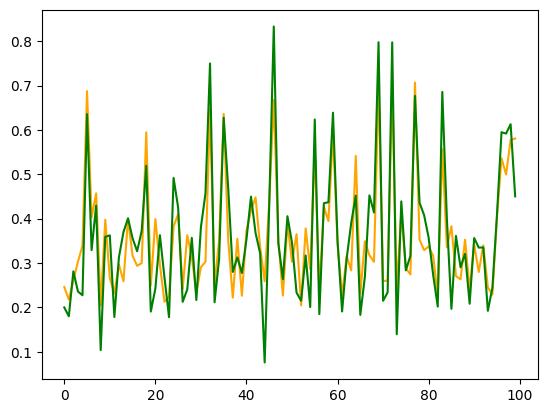

In [45]:
# Plotting the Model Prediction
# print(final_ytest.iloc[:100, 0].sort_index().values)
# src.plots.evaluate_predictions(final_ypred[:100, 0], final_ytest.iloc[:100, 0].sort_index().values, final_mse_test, name=f"RBF Time series")
plt.plot(range(100), final_ypred[:100, 0], label='Predicted Mz1', color = 'orange')
plt.plot(range(100),final_ytest.iloc[:100, 0], label='Actual Mz1', color='green')
# plt.xlabel('time')
# plt.ylabel('Mz1')
# plt.legend()
# plt.show()


In [26]:
error = final_ytest.iloc[:, 0]- final_ypred[:, 0]


In [27]:
def find_max_sum_interval(array, interval_length):
    # Ensure the interval length is valid
    if interval_length > len(array):
        raise ValueError("Interval length must be smaller than or equal to the array length.")

    # Calculate the sum of the first interval
    max_sum = current_sum = sum(array.iloc[:interval_length])
    max_start_index = 0

    # Slide the window across the array
    for i in range(1, len(array) - interval_length + 1):
        # Update the sum by removing the first element of the previous window and adding the next element
        current_sum = current_sum - array.iloc[i - 1] + array.iloc[i + interval_length - 1]
        if current_sum > max_sum:
            max_sum = current_sum
            max_start_index = i

    # Extract the interval with the highest sum
    max_interval = array.iloc[max_start_index:max_start_index + interval_length]
    return max_interval, max_start_index

max_error_interval, max_t_index = find_max_sum_interval(error, 100)
max_t_interval = range(max_t_index, max_t_index + 100)
error_first_part = error[:100]

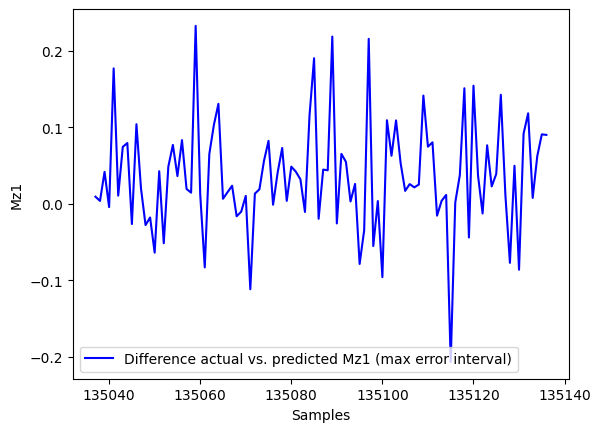

In [28]:
# Plotting the Error of the max error interval
plt.plot(max_t_interval, max_error_interval, label='Difference actual vs. predicted Mz1 (max error interval)', color = 'blue')
plt.xlabel('Samples')
plt.ylabel('Mz1')
plt.legend()
plt.show()

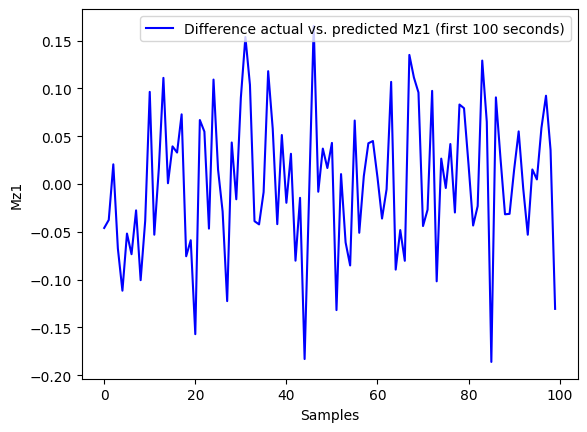

In [29]:
# Plotting the Error of the first 100 seconds
plt.plot(range(100), error_first_part, label='Difference actual vs. predicted Mz1 (first 100 seconds)', color = 'blue')
plt.xlabel('Samples')
plt.ylabel('Mz1')
plt.legend()
plt.show()